In [12]:
import pandas as pd
import numpy as np
import re
import nltk
from time import time
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [37]:
df=pd.read_csv('tweetdata.csv')
df.drop(['Unnamed: 0','id','score'],axis=1,inplace=True)

In [38]:
import seaborn as sns

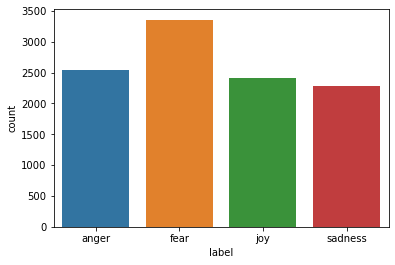

In [39]:
sns.countplot(x='label', data=df)

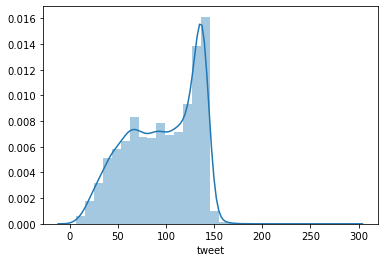

In [40]:
sns.distplot(df.tweet.apply(lambda tweet: len(tweet)), bins=30)

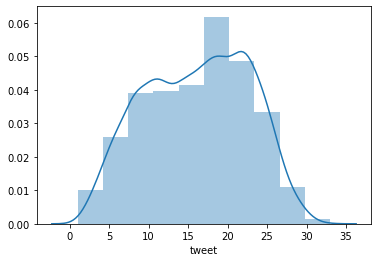

In [41]:
sns.distplot(df.tweet.apply(lambda tweet: len(tweet.split())), bins=10)

In [26]:
import string
punctuations = string.punctuation
from nltk.corpus import stopwords
stopword_list = stopwords.words("english")  # List that contains stopwords to reduce noise
from nltk.stem.wordnet import WordNetLemmatizer
lem = WordNetLemmatizer()

In [30]:
def clean_str(text):
    cleaned_text = text.lower()
    cleaned_text=re.sub("[^a-zA-Z]"," ",cleaned_text) #extracting all the words
    cleaned_text=re.sub(r'\b\w{1,3}\b', '',cleaned_text) #removing words with less than 3

    cleaned_text = "".join(c for c in cleaned_text if c not in punctuations) #removing punctuation from the data
    words = cleaned_text.split()
    words = [w for w in words if w not in stopword_list]
    
    
     #lemmatization
    words = [lem.lemmatize(word,"v") for word in words]
    words = [lem.lemmatize(word,"n") for word in words]
    words = [lem.lemmatize(word,"r") for word in words]
    cleaned_text = " ".join(words)
    
    return cleaned_text

In [44]:
df['text']=df['tweet'].apply(clean_str)
df.drop(['tweet'],axis=1,inplace=True)



In [46]:
df.head()

,label,text
0,anger,point today someone say something remotely kin...
1,anger,corningfootball game minus relentless
2,anger,game piss game year blood boil time turn stlcards
3,anger,spamvicious find candice candace pout like
4,anger,moocowward mrsajhargreaves melly garybarlow co...


In [47]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [49]:
num_words = 10000

tokenizer = Tokenizer(num_words=num_words, lower=True)
tokenizer.fit_on_texts(df.text)

In [50]:
from sklearn.model_selection import train_test_split

In [51]:
data = df.copy()

train = pd.DataFrame(columns=['label', 'text'])
validation = pd.DataFrame(columns=['label', 'text'])
for label in data.label.unique():
    label_data = data[data.label == label]
    train_data, validation_data = train_test_split(label_data, test_size=0.3)
    train = pd.concat([train, train_data])
    validation = pd.concat([validation, validation_data])

In [52]:
from tensorflow.keras.layers import Input, Embedding, SpatialDropout1D, LSTM
from tensorflow.keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D
from tensorflow.keras.layers import Bidirectional, Conv1D, Dense, concatenate
from tensorflow.keras.models import Model

In [76]:
input_dim = min(tokenizer.num_words, len(tokenizer.word_index) + 1)
num_classes = len(data.label.unique())
embedding_dim = 200
input_length = 12
lstm_units = 128
lstm_dropout = 0.1
recurrent_dropout = 0.1
spatial_dropout=0.2
filters=64
kernel_size=3

In [77]:
input_layer = Input(shape=(input_length,))
output_layer = Embedding(
  input_dim=input_dim,
  output_dim=embedding_dim,
  input_shape=(input_length,)
)(input_layer)

output_layer = SpatialDropout1D(spatial_dropout)(output_layer)

output_layer = Bidirectional(
LSTM(lstm_units, return_sequences=True,
     dropout=lstm_dropout, recurrent_dropout=recurrent_dropout)
)(output_layer)
output_layer = Conv1D(filters, kernel_size=kernel_size, padding='valid',
                    kernel_initializer='glorot_uniform')(output_layer)

avg_pool = GlobalAveragePooling1D()(output_layer)
max_pool = GlobalMaxPooling1D()(output_layer)
output_layer = concatenate([avg_pool, max_pool])

output_layer = Dense(num_classes, activation='softmax')(output_layer)

model = Model(input_layer, output_layer)

In [78]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 12)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 12, 200)      2000000     input_2[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 12, 200)      0           embedding_1[0][0]                
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 12, 256)      336896      spatial_dropout1d_1[0][0]        
_______________________________________________________________________________________

In [56]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelBinarizer

In [57]:
train_sequences = [text.split() for text in train.text]
validation_sequences = [text.split() for text in validation.text]
list_tokenized_train = tokenizer.texts_to_sequences(train_sequences)
list_tokenized_validation = tokenizer.texts_to_sequences(validation_sequences)
x_train = pad_sequences(list_tokenized_train, maxlen=input_length)
x_validation = pad_sequences(list_tokenized_validation, maxlen=input_length)

encoder = LabelBinarizer()
encoder.fit(data.label.unique())

y_train = encoder.transform(train.label)
y_validation = encoder.transform(validation.label)

In [63]:
batch_size = 128
epochs = 1

In [64]:
model.fit(x_train,y=y_train,batch_size=batch_size,epochs=epochs,validation_data=(x_validation, y_validation))

58/58 [==============================] - 397s 7s/step - loss: 0.1098 - accuracy: 0.9637 - val_loss: 0.2889 - val_accuracy: 0.9085
